In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from patch_gnn.data import load_ghesquire
import pandas as pd
from pyprojroot import here
import pickle as pkl
from patch_gnn.splitting import train_test_split
from jax import random
from patch_gnn.seqops import one_hot
from patch_gnn.unirep import unirep_reps
from patch_gnn.graph import graph_tensors
from patch_gnn.models import MPNN, DeepMPNN
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score as evs
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error as mse
import pickle as pkl
from patch_gnn.graph import met_position
import seaborn as sns

In [3]:
data = load_ghesquire()

graph_pickle_path = here() / "data/ghesquire_2011/graphs.pkl"

with open(graph_pickle_path, "rb") as f:
    graphs = pkl.load(f)

key = random.PRNGKey(490)

In [4]:
data.head()

,accession,Description,sequence,isoforms,end,score,threshold,m/z,z,ppm,%ox_fwd,val_fwd,%ox_rev,val_rev,ox_fwd_logit,ox_rev_logit,accession-sequence
0,A0AVT1,Ubiquitin-like modifier-activating enzyme 6,GMITVTDPDLIEK,NaN,503.0,79.0,32.0,732.3690,2.0,0.546925,10.756459,V,7.676,NaN,-2.115863,-2.487206,A0AVT1-GMITVTDPDLIEK
1,A0AVT1,NaN,YVLGDTAMQK,NaN,58.0,58.0,33.0,579.2792,2.0,0.345858,11.870662,V,1.394,NaN,-2.004736,-4.258955,A0AVT1-YVLGDTAMQK
2,A2RRP1,Neuroblastoma-amplified gene protein,DIVQSAIMK,NaN,2043.0,44.0,32.0,518.7707,2.0,0.096569,11.697357,NaN,19.339,NaN,-2.021407,-1.428131,A2RRP1-DIVQSAIMK
3,A2RRP1,NaN,LATVMLTR,NaN,2207.0,50.0,35.0,468.7624,2.0,0.855148,0.176751,NaN,NaN,NaN,-4.595120,NaN,A2RRP1-LATVMLTR
4,A3KN83,Protein strawberry notch homolog 1,NALEIVMK,NaN,1051.0,37.0,35.0,475.2548,2.0,0.000000,0.209183,NaN,NaN,NaN,-4.595120,NaN,A3KN83-NALEIVMK


In [5]:
filtered = (
    data
    .query("`accession-sequence` in @graphs.keys()")
    .query("ox_fwd_logit < 2.0")
    .join_apply(met_position, "met_position")
)

In [6]:
train_df, test_df = train_test_split(key, filtered) # 70% training, 30% testing

In [7]:
(train_df.shape), (test_df.shape)

((258, 18), (111, 18))

In [8]:
train_oh = one_hot(train_df, 50) #pad sequence to 50 length and one hot encode it
test_oh = one_hot(test_df, 50)

train_unirep = unirep_reps(train_df) # unirep representation of the sequence
test_unirep = unirep_reps(test_df)

train_graph = graph_tensors(train_df, graphs) # use graph + sasa features
test_graph = graph_tensors(test_df, graphs)

In [8]:
with open(here() / "data/ghesquire_2011/sasa.pkl", "rb") as f:
    sasa_dfs = pkl.load(f)

In [9]:
sasa_dfs["O15305"]

,ResidNe,Chain,ResidNr,iCode,Phob/A^2,Phil/A^2,SASA/A^2,Q(SASA),N(overl),Surf/A^2
0,PRO,-,4,-,99.79,7.32,107.12,0.6476,348,165.4
1,GLY,-,5,-,37.79,27.27,65.06,0.5368,192,121.2
2,PRO,-,6,-,96.03,4.12,100.15,0.6055,400,165.4
3,ALA,-,7,-,10.52,6.56,17.09,0.1184,452,144.3
4,LEU,-,8,-,7.74,2.43,10.17,0.0647,898,157.1
...,...,...,...,...,...,...,...,...,...,...
238,GLU,-,242,-,33.31,36.27,69.59,0.3455,479,201.4
239,LEU,-,243,-,112.63,16.03,128.66,0.8190,328,157.1
240,LEU,-,244,-,19.86,13.01,32.87,0.2092,440,157.1
241,PHE,-,245,-,27.41,7.35,34.76,0.2029,588,171.3


In [10]:
def linear_model_data(df, sasa_dfs):
    linear = []
    for acc, pos in zip(df["accession"], df["met_position"]):
        feats = sasa_dfs[acc].query("ResidNr == @pos")[["SASA/A^2", "N(overl)"]]
        linear.append(feats)

    return pd.concat(linear)

train_linear = linear_model_data(train_df, sasa_dfs)
test_linear = linear_model_data(test_df, sasa_dfs)

In [11]:
train_target = train_df['ox_fwd_logit'].values
test_target = test_df['ox_fwd_logit'].values

### try new fluc descriptor ANM

In [5]:
with open(here() / "data/ghesquire_2011/ANM.pkl", "rb") as f:
    sasa_dfs = pkl.load(f)

In [6]:
len(sasa_dfs)

810

In [7]:
sasa_dfs['P05386'] # will return fluc with inf

,chains,resnos,resids,fluc
0,NaN,1,MET,inf
1,NaN,2,ALA,inf
2,NaN,3,SER,inf
3,NaN,4,VAL,inf
4,NaN,5,SER,inf
...,...,...,...,...
109,NaN,110,PHE,inf
110,NaN,111,GLY,inf
111,NaN,112,LEU,inf
112,NaN,113,PHE,inf


In [16]:
import numpy as np
import math
def linear_model_data(df, sasa_dfs):
    linear = []
    for acc, pos in zip(df["accession"], df["met_position"]):
        sasa_dfs[acc] = sasa_dfs[acc].replace(np.inf, 100000000)
        feats = sasa_dfs[acc].query("resnos == @pos")[["fluc"]]
        #sasa_dfs[acc]['fluc'] = sasa_dfs[acc]['fluc'].apply(lambda x: x if not math.isinf(x) else 1000000 )
        
        #sasa_dfs[acc] = sasa_dfs[acc].replace(to_replace=r'inf', value='10000000', regex=True)
        #sasa_dfs[acc]['fluc'] = sasa_dfs[acc]['fluc'].apply(lambda x: x if type(x) != float64 else 1000000 )
        #sasa_dfs[acc] = sasa_dfs[acc].replace({'fluc': 'inf'}, {'fluc': '1000000000'}, regex=True)
        #sasa_dfs[acc]['fluc'] = np.where('fluc' > 1000000000, 10000000, 'fluc') 
        linear.append(feats)

    return pd.concat(linear)

train_linear = linear_model_data(train_df, sasa_dfs)
test_linear = linear_model_data(test_df, sasa_dfs)

In [39]:
np.isinf(train_linear).any(), np.isinf(test_linear).any() # no more inf values

(fluc    False
 dtype: bool,
 fluc    False
 dtype: bool)

In [18]:
#sasa_dfs['P05386'].replace([np.inf, -np.inf], 100000000)

In [19]:
train_target = train_df['ox_fwd_logit'].values
test_target = test_df['ox_fwd_logit'].values

In [20]:
len(filtered)

369

In [21]:
num_training_steps = 5000

models = {
    "mpnn": MPNN(
        node_feature_shape=(20, 65),
        num_adjacency=1,
        num_training_steps=num_training_steps
    ),
    "deep_mpnn": DeepMPNN(
        node_feature_shape=(20, 65),
        num_adjacency=1,
        num_training_steps=num_training_steps
    ),
    "rf_oh": RandomForestRegressor(n_estimators=300),
    "rf_unirep": RandomForestRegressor(n_estimators=300),
}

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
model_linear = LinearRegression()
model_linear.fit(train_linear, train_target)

LinearRegression()

In [24]:
model_mpnn = MPNN(
    node_feature_shape=(20, 65),
    num_adjacency=1,
    num_training_steps=num_training_steps
)
model_mpnn.fit(train_graph, train_target)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [25]:
model_deepmpnn = DeepMPNN(
    node_feature_shape=(20, 65),
    num_adjacency=1,
    num_training_steps=num_training_steps
)
model_deepmpnn.fit(train_graph, train_target)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [26]:
model_rfoh = RandomForestRegressor(oob_score=True, n_jobs=-1)
model_rfoh.fit(train_oh, train_target)

model_rf_unirep = RandomForestRegressor(oob_score=True, n_jobs=-1)
model_rf_unirep.fit(train_unirep, train_target)

RandomForestRegressor(n_jobs=-1, oob_score=True)

In [27]:
def plot_y_eq_x(ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    minval = min(xmin, ymin)
    maxval = max(xmax, ymax)

    ax.plot([minval, maxval], [minval, maxval])

def plot_performance(
    model,
    trainX, trainY, testX, testY,
    model_name: str,
    ev_func,
    checkpoint: int = None,
):
    fig, ax = plt.subplots(
        figsize=(10, 5), nrows=1, ncols=2, sharex=True, sharey=True,
    )

    if isinstance(model, MPNN):
        train_preds = model.predict(trainX, checkpoint=checkpoint)
    else:
        train_preds = model.predict(trainX)
    ax[0].scatter(trainY, train_preds.squeeze())
    ax[0].set_title(f"Model: {model_name}, Training Perf: {ev_func(trainY, train_preds.squeeze()):.3f}")
    plot_y_eq_x(ax[0])

    if isinstance(model, MPNN):
        test_preds = model.predict(testX, checkpoint=checkpoint)
    else:
        test_preds = model.predict(testX)
    ax[1].scatter(testY, test_preds.squeeze())
    ax[1].set_title(f"Model: {model_name}, Testing Perf: {ev_func(testY, test_preds.squeeze()):.3f}")
    plot_y_eq_x(ax[1])

## Baseline Model Performance

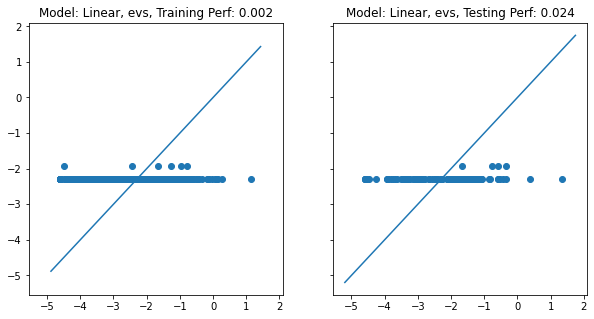

In [28]:
plot_performance(model_linear, train_linear, train_target, test_linear, test_target, 'Linear, evs', evs)


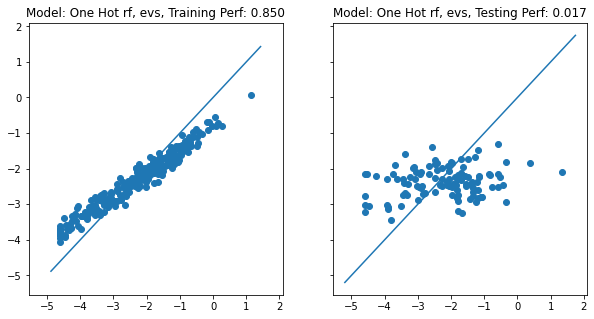

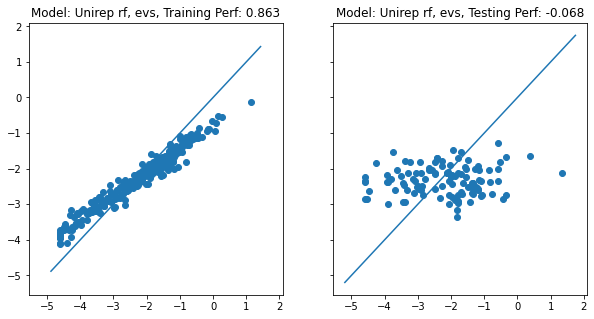

In [29]:
plot_performance(model_rfoh, train_oh, train_target, test_oh, test_target, 'One Hot rf, evs', evs)
plot_performance(model_rf_unirep, train_unirep, train_target, test_unirep, test_target, 'Unirep rf, evs', evs)

## Which checkpoint for NN models?

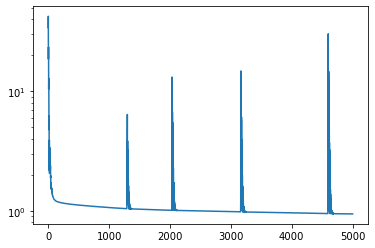

In [30]:
plt.plot(model_mpnn.loss_history)
plt.yscale("log")

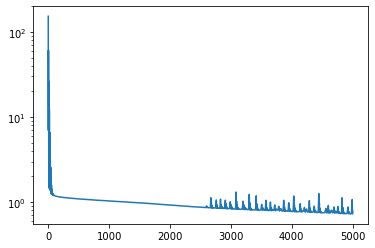

In [31]:
plt.plot(model_deepmpnn.loss_history)
plt.yscale("log")

## Checkpoint at 400 steps

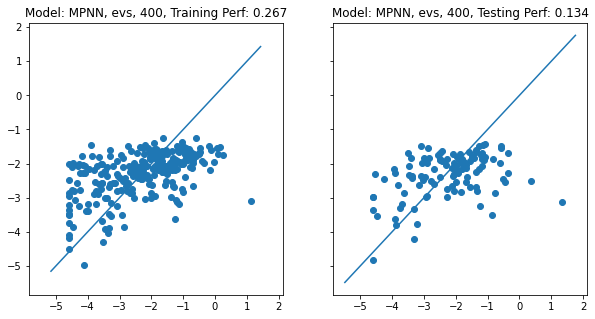

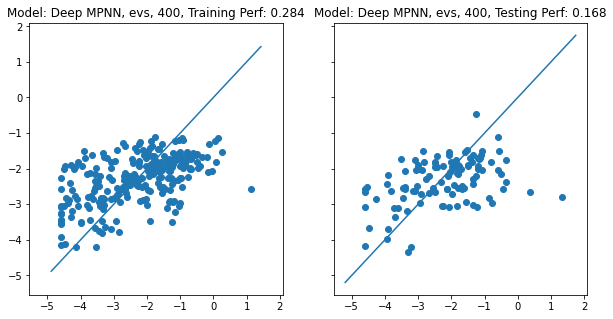

In [32]:
checkpoint = 400
plot_performance(model_mpnn, train_graph, train_target, test_graph, test_target, f'MPNN, evs, {checkpoint}', evs, checkpoint=checkpoint)
plot_performance(model_deepmpnn, train_graph, train_target, test_graph, test_target, f'Deep MPNN, evs, {checkpoint}', evs, checkpoint=checkpoint)


## Checkpoint at 600 steps

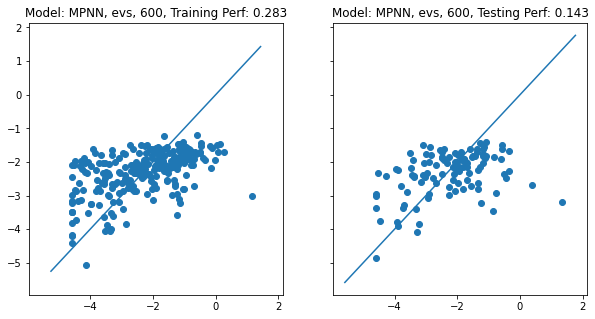

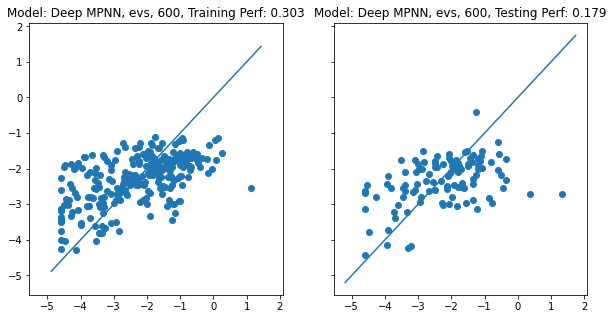

In [33]:
checkpoint = 600
plot_performance(model_mpnn, train_graph, train_target, test_graph, test_target, f'MPNN, evs, {checkpoint}', evs, checkpoint=checkpoint)
plot_performance(model_deepmpnn, train_graph, train_target, test_graph, test_target, f'Deep MPNN, evs, {checkpoint}', evs, checkpoint=checkpoint)


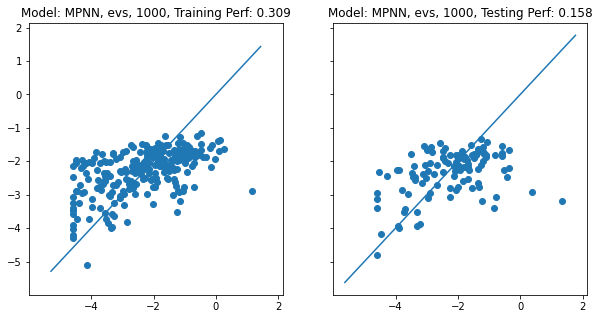

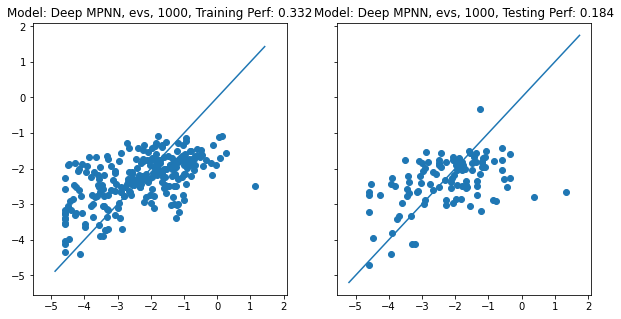

In [34]:
checkpoint = 1000
plot_performance(model_mpnn, train_graph, train_target, test_graph, test_target, f'MPNN, evs, {checkpoint}', evs, checkpoint=checkpoint)
plot_performance(model_deepmpnn, train_graph, train_target, test_graph, test_target, f'Deep MPNN, evs, {checkpoint}', evs, checkpoint=checkpoint)


## Checkpoint at Final steps

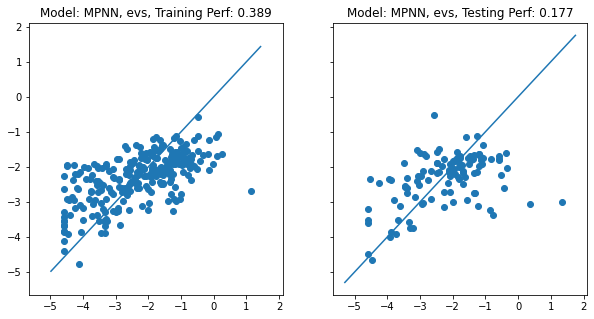

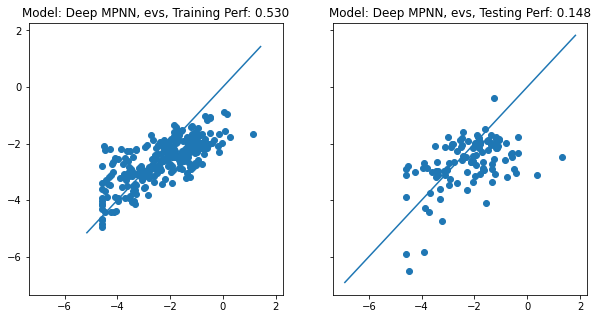

In [35]:
plot_performance(model_mpnn, train_graph, train_target, test_graph, test_target, 'MPNN, evs', evs, checkpoint=-1)
plot_performance(model_deepmpnn, train_graph, train_target, test_graph, test_target, 'Deep MPNN, evs', evs, checkpoint=-1)

## plot descriptor, target relation scatter plot

In [94]:
descriptor = pd.concat([train_linear.reset_index(drop=True), test_linear.reset_index(drop=True)], axis=0)
target = pd.concat([pd.Series(train_target), pd.Series(test_target)], axis=0)
train_test = pd.Series(["train"]*train_linear.shape[0] + ['test']* test_linear.shape[0])
scatter_df = pd.DataFrame({'fluc': descriptor['fluc'].tolist(), 'target': target.tolist(), 'train_test': train_test.tolist()})
scatter_df.shape

(369, 3)

In [95]:
scatter_df.head()

,fluc,target,train_test
0,0.714619,-4.595120,train
1,0.864497,-1.363307,train
2,0.529171,-3.985257,train
3,4.917406,-2.370775,train
4,0.461808,-1.631002,train


Text(0.5, 1.0, 'ANM fluc vs. target in train and test set')

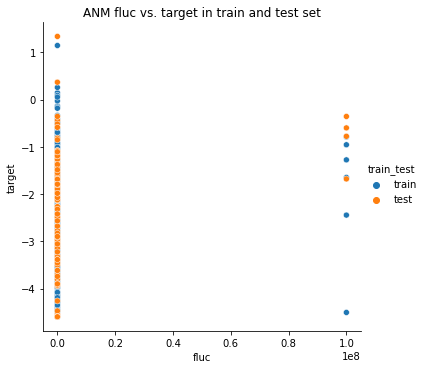

In [99]:
sns.relplot(x="fluc", y="target",hue="train_test", data=scatter_df)
plt.title('ANM fluc vs. target in train and test set')

In [101]:
np.where(scatter_df['fluc']==100000000)

(array([ 56,  71,  90, 142, 190, 207, 265, 279, 337, 341]),)

In [103]:
scatter_df.iloc[[ 56,  71,  90, 142, 190, 207, 265, 279, 337, 341],]

,fluc,target,train_test
56,100000000.0,-2.443772,train
71,100000000.0,-4.503528,train
90,100000000.0,-1.647774,train
142,100000000.0,-1.275522,train
190,100000000.0,-0.956179,train
207,100000000.0,-0.790045,train
265,100000000.0,-1.679378,test
279,100000000.0,-0.599100,test
337,100000000.0,-0.776624,test
341,100000000.0,-0.357101,test


In [104]:
# next we will try dropping them and see the performance of the model